<a href="https://colab.research.google.com/github/GodinaMohitheswar/Image-Classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up Kaggle API credentials:**

Ensure you have the kaggle.json file, which contains your Kaggle API credentials. You can download it from your Kaggle account settings.

**Create the necessary directories and copy the kaggle.json file:**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

**Download the dataset using Kaggle API:**

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:07<00:00, 288MB/s]
100% 1.06G/1.06G [00:07<00:00, 158MB/s]


**Unzip the downloaded dataset:**

In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

**Importing necessary libraries:**

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import cv2

**Adding data augmentation to the training pipeline to improve model robustness:**

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = datagen.flow_from_directory(
    '/content/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_ds = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


**Loading the VGG16 model with pretrained weights, excluding the top layers:**

In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 0s 0us/step


**Adding custom layers on top of the base model:**

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

**Freezing the base model layers:**

In [10]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Traing the model:**

In [11]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
625/625 [==============================] - 418s 651ms/step - loss: 0.3880 - accuracy: 0.8210 - val_loss: 0.2230 - val_accuracy: 0.9112
Epoch 2/10
625/625 [==============================] - 380s 608ms/step - loss: 0.2738 - accuracy: 0.8813 - val_loss: 0.1879 - val_accuracy: 0.9276
Epoch 3/10
625/625 [==============================] - 389s 622ms/step - loss: 0.2528 - accuracy: 0.8930 - val_loss: 0.1793 - val_accuracy: 0.9312
Epoch 4/10
625/625 [==============================] - 391s 625ms/step - loss: 0.2425 - accuracy: 0.8974 - val_loss: 0.1766 - val_accuracy: 0.9276
Epoch 5/10
625/625 [==============================] - 407s 651ms/step - loss: 0.2364 - accuracy: 0.9001 - val_loss: 0.1754 - val_accuracy: 0.9300
Epoch 6/10
625/625 [==============================] - 365s 585ms/step - loss: 0.2358 - accuracy: 0.8971 - val_loss: 0.1660 - val_accuracy: 0.9328
Epoch 7/10
625/625 [==============================] - 368s 588ms/step - loss: 0.2330 - accuracy: 0.8999 - val_loss: 0.1646 -

**Printing the final accuracy values for the training and validation sets:**

In [12]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Training Accuracy: 0.9026
Final Validation Accuracy: 0.9330


**Unfreezing some layers in the base model for fine-tuning:**

In [13]:
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
625/625 [==============================] - 402s 638ms/step - loss: 0.1671 - accuracy: 0.9331 - val_loss: 0.0877 - val_accuracy: 0.9634
Epoch 2/10
625/625 [==============================] - 564s 902ms/step - loss: 0.1253 - accuracy: 0.9499 - val_loss: 0.0729 - val_accuracy: 0.9724
Epoch 3/10
625/625 [==============================] - 391s 625ms/step - loss: 0.1023 - accuracy: 0.9592 - val_loss: 0.0728 - val_accuracy: 0.9708
Epoch 4/10
625/625 [==============================] - 377s 603ms/step - loss: 0.0881 - accuracy: 0.9649 - val_loss: 0.0788 - val_accuracy: 0.9686
Epoch 5/10
625/625 [==============================] - 375s 600ms/step - loss: 0.0804 - accuracy: 0.9682 - val_loss: 0.0656 - val_accuracy: 0.9748
Epoch 6/10
625/625 [==============================] - 376s 601ms/step - loss: 0.0705 - accuracy: 0.9719 - val_loss: 0.0731 - val_accuracy: 0.9724
Epoch 7/10
625/625 [==============================] - 377s 603ms/step - loss: 0.0615 - accuracy: 0.9752 - val_loss: 0.0643 -

**Printing the final fine-tuning accuracy values for the training and validation sets:**

In [14]:
train_accuracy_fine = history_fine.history['accuracy'][-1]
val_accuracy_fine = history_fine.history['val_accuracy'][-1]
print(f"Final Fine-tuning Training Accuracy: {train_accuracy_fine:.4f}")
print(f"Final Fine-tuning Validation Accuracy: {val_accuracy_fine:.4f}")

Final Fine-tuning Training Accuracy: 0.9794
Final Fine-tuning Validation Accuracy: 0.9784


**Plotting Training History:**

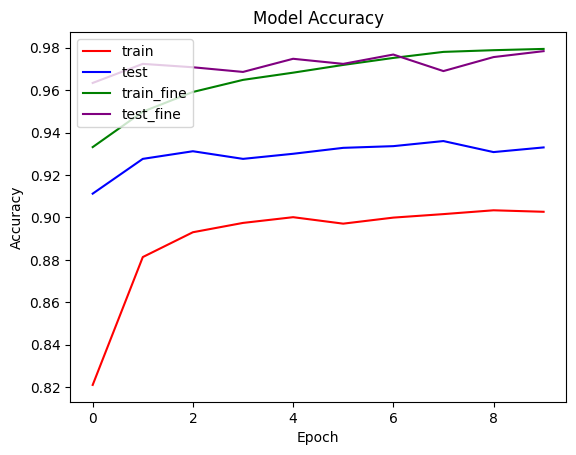

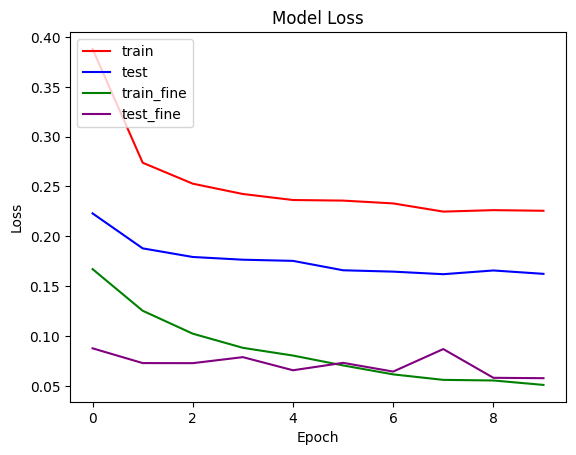

In [16]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='test')
plt.plot(history_fine.history['accuracy'], color='green', label='train_fine')
plt.plot(history_fine.history['val_accuracy'], color='purple', label='test_fine')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='test')
plt.plot(history_fine.history['loss'], color='green', label='train_fine')
plt.plot(history_fine.history['val_loss'], color='purple', label='test_fine')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**Testing the Model:**

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_image_label(image_path, model):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256))
    img_normalized = img_resized.astype('float32') / 255.0
    img_reshaped = img_normalized.reshape(1, 256, 256, 3)

    prediction = model.predict(img_reshaped)
    label = "Cat" if prediction < 0.5 else "Dog"

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

    return label

**Displaying the image with the prediction label:**

1/1 [==============================] - 0s 26ms/step


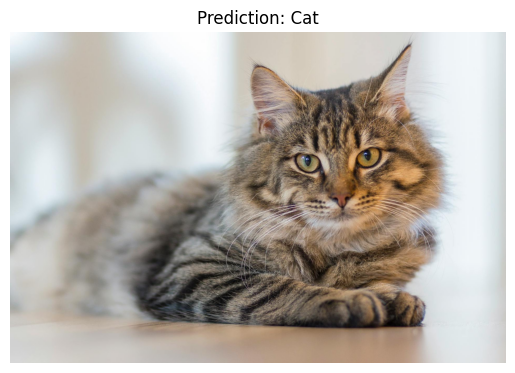

Prediction: Cat


In [27]:
image_path = "/content/cat.jpg"
label = predict_image_label(image_path, model)
print("Prediction:", label)

1/1 [==============================] - 0s 18ms/step


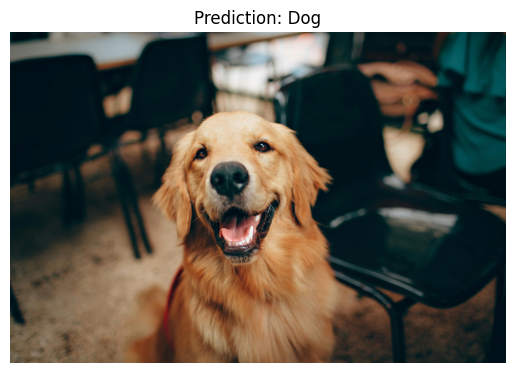

Prediction: Dog


In [28]:
image_path = "/content/dog.jpg"
label = predict_image_label(image_path, model)
print("Prediction:", label)